# Spot A Bot 

Is it possible to know who is a robot?

Twitter features:
https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object

- The Train dataset data was collected as shown in the Collector_data_bots.ipynb notebook and data released by NBC
- The Test dataset data has been collected through streaming applications created for this project and hosted on kubernetes

In [2]:
import sys
#sys.path.append("../tools/")

from sklearn import model_selection
from time import time
import pandas as pd
import numpy as np
import seaborn as sb
import re

from sklearn.model_selection import StratifiedShuffleSplit
    
# Preprocessing
from sklearn.preprocessing import  MaxAbsScaler, StandardScaler, MinMaxScaler

#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest,chi2, f_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier

#Feature selection
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest,chi2, f_regression

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline


# Set Variables

In [2]:
target_label = 'bot'      

# Data Cleansing

# Preparing for split

In [23]:
df = pd.read_csv('bot_train.csv', sep=',')

In [24]:
df.head()

,Unnamed: 0,favourites_count,followers_count,bot,listed_count,statuses_count,verified,creation_days,description_count,polarity,subjectivity,sentiment_negative,sentiment_neutral,sentiment_positive
0,0,11,110312767,0,228446,15688,1,4646,4,0.000000,0.000000,0,1,0
1,1,11,110312766,0,228446,15688,1,4646,4,0.000000,0.000000,0,1,0
2,2,1021,94507574,0,102466,10434,1,3704,18,0.566667,0.966667,0,0,1
3,3,6,66882912,0,110763,46279,1,3902,8,0.000000,0.000000,0,1,0
4,4,11851,415584,0,7530,34320,1,3958,24,0.000000,0.000000,0,1,0


## SMOTE - Balance

In [25]:
y = df['bot']
X = df.drop('bot', 1)

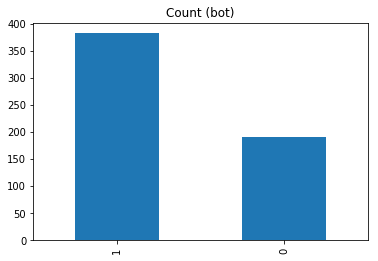

In [26]:
df['bot'].value_counts().plot(kind='bar', title='Count (bot)');

In [27]:

#features_train, features_test, labels_train, labels_test
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X, y)

df = pd.DataFrame(X_sm, columns=X.columns)
df['bot'] = y_sm
del df["Unnamed: 0"]
df = df[['favourites_count', 'followers_count', 'bot', 'listed_count', 'statuses_count', 'verified', 'creation_days', 'description_count', 
 'polarity', 'subjectivity', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']]

#df.to_csv('train_data.csv', sep=',')

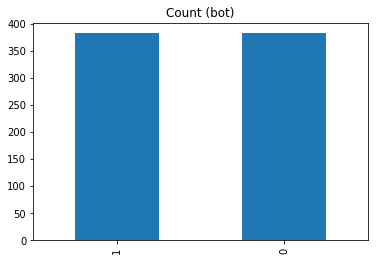

In [28]:
df['bot'].value_counts().plot(kind='bar', title='Count (bot)');

# Split

In [30]:
y = df['bot']
X = df.drop('bot', 1)

In [31]:
# Split the dataset into train and test
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(X, 
                                                                                            y,  
                                                                                            test_size=0.1, 
                                                                                            random_state=42)


In [32]:
features_list= ['favourites_count', 'followers_count', 'listed_count','statuses_count', 'verified',
'polarity', 'subjectivity','sentiment' ,'creation_days' ,'description_count']

# Selecting features

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


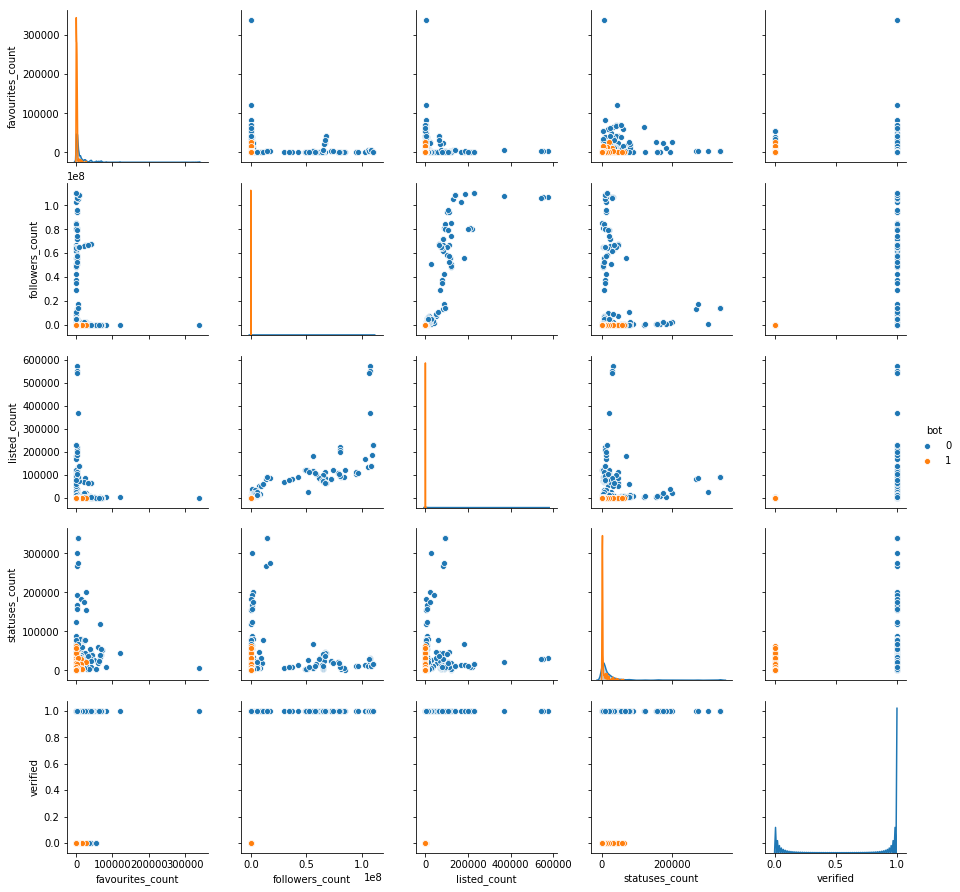

In [33]:
sb.pairplot(df, vars=['favourites_count', 'followers_count', 'listed_count','statuses_count', 'verified'], hue='bot')

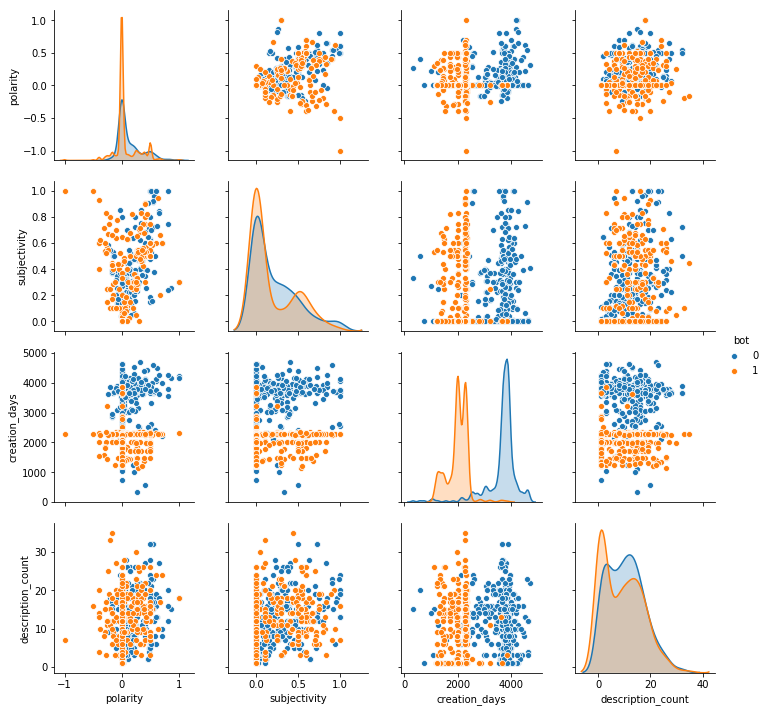

In [34]:
sb.pairplot(df, vars=['polarity', 'subjectivity','creation_days' ,'description_count'], hue='bot')

In [35]:
df.corr()

,favourites_count,followers_count,bot,listed_count,statuses_count,verified,creation_days,description_count,polarity,subjectivity,sentiment_negative,sentiment_neutral,sentiment_positive
favourites_count,1.000000,-0.018035,-0.210693,-0.026028,0.116571,0.183990,0.153220,0.091327,0.024875,0.134302,0.063334,-0.123861,0.045237
followers_count,-0.018035,1.000000,-0.304516,0.832300,0.068718,0.326783,0.371726,-0.157990,0.119132,0.079373,-0.075484,-0.063857,0.034799
bot,-0.210693,-0.304516,1.000000,-0.277473,-0.263854,-0.931649,-0.856386,-0.096727,-0.148682,-0.060710,0.161806,0.154642,0.026669
listed_count,-0.026028,0.832300,-0.277473,1.000000,0.176906,0.297325,0.347299,-0.119933,0.141397,0.068209,-0.065107,-0.080469,0.067385
statuses_count,0.116571,0.068718,-0.263854,0.176906,1.000000,0.286385,0.330691,0.108933,0.071529,-0.027768,-0.024573,-0.044681,0.018309
verified,0.183990,0.326783,-0.931649,0.297325,0.286385,1.000000,0.811703,0.104975,0.125113,0.032143,-0.141713,-0.148873,-0.025702
creation_days,0.153220,0.371726,-0.856386,0.347299,0.330691,0.811703,1.000000,0.064145,0.148119,0.086890,-0.115883,-0.156463,-0.006230
description_count,0.091327,-0.157990,-0.096727,-0.119933,0.108933,0.104975,0.064145,1.000000,0.305709,0.439148,0.150120,-0.469172,0.415430
polarity,0.024875,0.119132,-0.148682,0.141397,0.071529,0.125113,0.148119,0.305709,1.000000,0.545691,-0.401181,-0.493316,0.728996
subjectivity,0.134302,0.079373,-0.060710,0.068209,-0.027768,0.032143,0.086890,0.439148,0.545691,1.000000,0.267178,-0.767743,0.654717


In [36]:
df.to_csv('bot_train.csv')

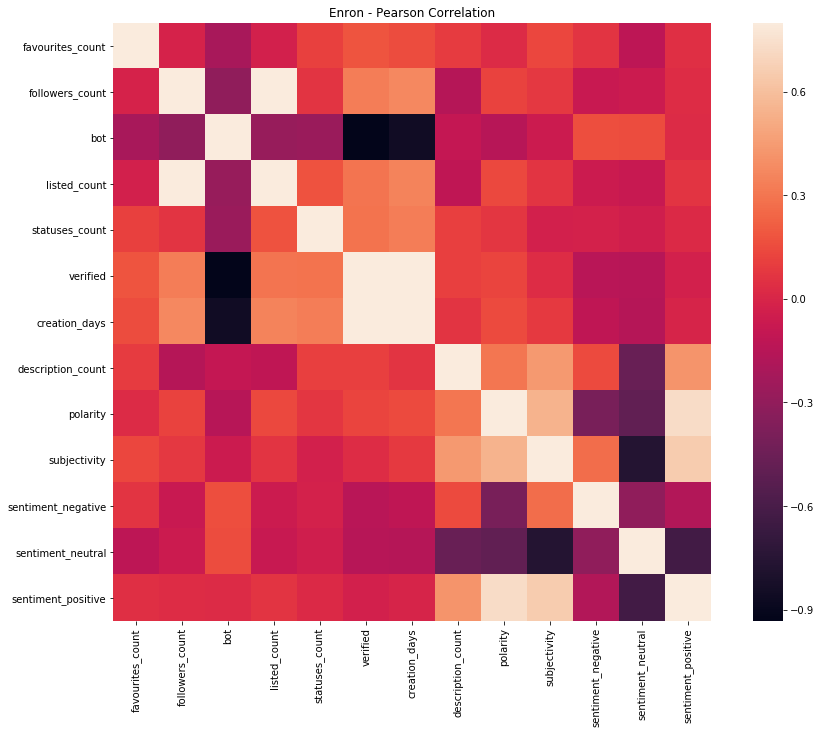

In [37]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 11))

# Draw the heatmap using seaborn
sb.heatmap(corr, vmax=.8, square=True)
plt.title('Enron - Pearson Correlation');

In [38]:
for i in range(1,13):
    pca = PCA(svd_solver='auto', n_components=i)
    x = pca.fit(features_train).explained_variance_ratio_.sum()
    print(i,":", x)

1 : 0.9999950600824842
2 : 0.9999981497301527
3 : 0.9999994134273146
4 : 0.9999999984679941
5 : 0.9999999999998854
6 : 1.0000000000000007
7 : 1.0000000000000018
8 : 1.0000000000000033
9 : 1.0000000000000027
10 : 1.0
11 : 1.0
12 : 1.0


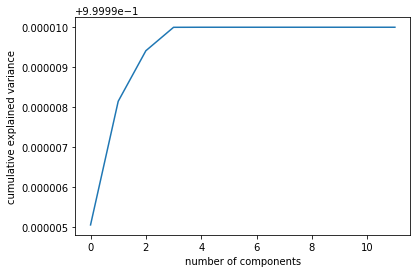

In [39]:
pca = PCA().fit(features_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

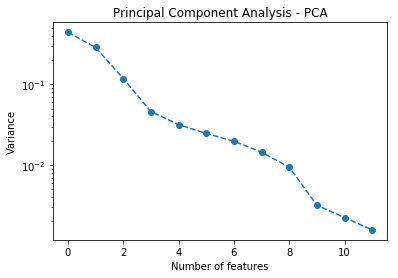

In [40]:
from sklearn.preprocessing import StandardScaler

z_scaler = MinMaxScaler(feature_range=(0, 1))

z_data = z_scaler.fit_transform(features_train)
pca_trafo = PCA().fit(z_data);

plt.semilogy(pca_trafo.explained_variance_ratio_, '--o')
plt.title('Principal Component Analysis - PCA')
plt.xlabel('Number of features')
plt.ylabel('Variance');


In [41]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [49]:
model = LogisticRegression(C=0.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.1, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False)
rfe = RFE(model, 4)
fit = rfe.fit(features_train, labels_train)
print(X.columns)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_));

#favourites_count, followers_count, statuses_count, creation_days, listed_count, description_count

Index(['favourites_count', 'followers_count', 'listed_count', 'statuses_count',
       'verified', 'creation_days', 'description_count', 'polarity',
       'subjectivity', 'sentiment_negative', 'sentiment_neutral',
       'sentiment_positive'],
      dtype='object')
Num Features: 4
Selected Features: [ True  True False  True False  True False False False False False False]
Feature Ranking: [1 1 2 1 5 1 3 9 8 7 4 6]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elas

# Testing Models

In [17]:
#df.drop(['description_count','polarity', 'subjectivity','sentiment_negative','sentiment_neutral','sentiment_positive'],axis=1, inplace=True)

In [50]:
from sklearn.metrics import classification_report

models = []
# naive_bayes
models.append(('Naive Bayes', GaussianNB()))
# tree
models.append(('DecisionTree', DecisionTreeClassifier(random_state=42)))
# ensemble
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)))

models.append(('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=100, random_state=42)))
# linear_model
models.append(('LogisticRegression', LogisticRegression(random_state=42)))
# neighbors
models.append(('KNeighbors', KNeighborsClassifier(n_neighbors=5)))
models.append(('NearestCentroid', NearestCentroid()))

accuracy_model = []
score = []
for name, clf in models:  
    tm = time()
    #print "Start testing classifier:", name

    clf.fit(features_train, labels_train)
    predicted = clf.predict(features_test)
    report= classification_report(labels_test, predicted)
    print(name)
    print(report)


Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        43
           1       0.80      0.94      0.86        34

    accuracy                           0.87        77
   macro avg       0.87      0.88      0.87        77
weighted avg       0.88      0.87      0.87        77

DecisionTree
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       1.00      0.94      0.97        34

    accuracy                           0.97        77
   macro avg       0.98      0.97      0.97        77
weighted avg       0.98      0.97      0.97        77

RandomForest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.97      0.99        34

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99   

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
df_report = pd.DataFrame(report)

In [31]:
report[1]

'             precision    recall  f1-score   support\n\n          0       0.97      1.00      0.98        64\n          1       1.00      0.98      0.99       108\n\navg / total       0.99      0.99      0.99       172\n'

# Tunning

In [51]:
combined_features = FeatureUnion([("pca", PCA(random_state=42)), 
                                  ('scale', MinMaxScaler(feature_range=(0, 1)))])



pipeline = Pipeline(steps=[('features', combined_features),
                           ('classifier', LogisticRegression(random_state=42))
                          ])

param_grid = {'features__scale': [StandardScaler(with_mean=False), None],
              'features__pca__n_components' :[3,5,6],
              'classifier__C': [0.05, 0.5, 1, 10, 100, 500, 1000],
              'classifier__solver': ['liblinear'],
              'classifier__penalty': ['l2'], 
              'classifier__class_weight': [None, 'balanced']
             }

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='f1')

grid.fit(features_train, labels_train)
clf = grid.best_estimator_
#test_classifier(clf, my_dataset, features_list, print_result=True)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is deprecated in version 0.22 and will be removed in version 0.24. Please use 'drop' instead.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\pipeline.py:855: FutureWarning: Using None as a transformer is dep

In [52]:
print(clf)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pca',
                                                 PCA(copy=True,
                                                     iterated_power='auto',
                                                     n_components=6,
                                                     random_state=42,
                                                     svd_solver='auto', tol=0.0,
                                                     whiten=False)),
                                                ('scale', None)],
                              transformer_weights=None, verbose=False)),
                ('classifier',
                 LogisticRegression(C=0.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                   

In [53]:
y_pred = clf.predict(features_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.94      0.94      0.94        34

    accuracy                           0.95        77
   macro avg       0.95      0.95      0.95        77
weighted avg       0.95      0.95      0.95        77



In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_test, predictions)

array([[ 59,   5],
       [  2, 106]], dtype=int64)

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
pipeline = Pipeline([('scale', StandardScaler(with_mean=False)),
                     ('classify', GradientBoostingClassifier(random_state=42))])

param_grid = {
        'classify__criterion': ['mae', 'friedman_mse', 'mse'],
        'classify__n_estimators' : [50, 100, 150],
        'classify__learning_rate':[0.05, 0.1, 1.0],
        'classify__loss' : ['deviance', 'exponential'],    
        'classify__max_leaf_nodes': [100, 150],
        'classify__max_features': [0.50]       
    }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

grid = GridSearchCV(
    pipeline, param_grid=param_grid, cv=cv, scoring='accuracy')

grid.fit(features_train, labels_train)
clf = grid.best_estimator_
#test_classifier(clf, my_dataset, features_list, print_result=True)

In [26]:
print(clf)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('classify',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=1.0, loss='deviance',
                                            max_depth=3, max_features=0.5,
                                            max_leaf_nodes=100,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=50,
                                            n_iter_no_change=None,
                

In [27]:
print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        64
           1       0.95      0.98      0.97       108

    accuracy                           0.96       172
   macro avg       0.96      0.95      0.96       172
weighted avg       0.96      0.96      0.96       172



In [85]:
# Adaboost
pipeline = Pipeline(steps=[('minmaxer', StandardScaler(with_mean=False)),
                           ('classifier', DecisionTreeClassifier(random_state=42))
                          ])
params = {
          'classifier__max_features': [2, 6, 10],
          'classifier__min_samples_split' : [0.1, .50, .90],
          'classifier__splitter' : ['best' , 'random'],
          'classifier__min_samples_leaf': [1, 3, 10,15],
          'classifier__class_weight' : ['balanced', None],
          'classifier__criterion': ["gini", "entropy"]
        }

grid = GridSearchCV(pipeline, param_grid = params,scoring = 'recall', cv=10)
grid.fit(features_train, labels_train)

clf_dt = grid.best_estimator_
cross_val_score(clf, X, y, scoring='recall_macro', cv=5)  


array([0.97419247, 0.97368421, 1.        , 0.98684211, 0.96052632])

In [87]:
grid.score(X, y)

1.0

In [28]:
# random Forest
pipeline =   Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                       ('classifier', RandomForestClassifier())
                      ])

param_grid = {'scale': [None, MaxAbsScaler(), MinMaxScaler(feature_range=(0, 1))],
              'classifier__max_depth': [5, 3, 1],
              'classifier__max_features': [2],
              'classifier__min_samples_leaf': [1, 3, 10,15],
              'classifier__bootstrap': [True, False],
              'classifier__criterion': ['gini', 'entropy']
             }

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='recall')

grid.fit(features_train, labels_train)

clf =  grid.best_estimator_
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, scoring='f1', cv=5)  

array([0.95890411, 1.        , 1.        , 1.        , 0.91566265])

In [129]:
print(grid.best_estimator_)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [32]:
print(classification_report(labels_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00       108

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172



In [163]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, scoring='recall_macro', cv=5)  

array([0.98717949, 0.98684211, 0.98684211, 1.        , 0.81578947])

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [120]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {  
  'learning_rate': 1,
  'max_depth' :2,
    'gamma':2,
    'eta':0.8,
    'reg_alpha':0.5,
    'reg_lambda':0.5
}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, stratified=True,
                   metrics= ["rmse","auc"], as_pandas=True)
cv_results

,train-auc-mean,train-auc-std,train-rmse-mean,train-rmse-std,test-auc-mean,test-auc-std,test-rmse-mean,test-rmse-std
0,0.993359,0.00204,0.079775,0.007833,0.992004,0.006389,0.090900,0.041345
1,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041268
2,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
3,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
4,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
5,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
6,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
7,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
8,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
9,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267


In [124]:
from xgboost import XGBClassifier
#features_train, features_test, labels_train, labels_test
m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
#m.fit(features_train, labels_train)
#m.predict_proba(features_test)[:,1]

model = XGBClassifier(max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5)
model.fit(features_train, labels_train)
# make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.84%


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [134]:
from sklearn.metrics import f1_score
f1 = f1_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.09%


In [118]:
cv_results

,train-auc-mean,train-auc-std,train-rmse-mean,train-rmse-std,test-auc-mean,test-auc-std,test-rmse-mean,test-rmse-std
0,0.999857,0.000104,0.144985,0.005749,0.999574,0.000439,0.154141,0.012653
1,0.999877,0.000090,0.081152,0.009742,0.999208,0.000795,0.100281,0.025114
2,0.999867,0.000101,0.065435,0.011996,0.999208,0.000795,0.088504,0.032838
3,0.999877,0.000090,0.060268,0.012351,0.999229,0.000767,0.085108,0.036124
4,0.999887,0.000081,0.057577,0.012361,0.999189,0.000897,0.083600,0.037078
5,0.999908,0.000067,0.054889,0.011274,0.998906,0.001293,0.082868,0.038673
6,0.999918,0.000063,0.052901,0.010216,0.998745,0.001520,0.082259,0.039590
7,0.999918,0.000063,0.050989,0.008983,0.998745,0.001520,0.081895,0.040556
8,0.999969,0.000025,0.049109,0.008022,0.998825,0.001406,0.081773,0.041341
9,0.999969,0.000025,0.047347,0.007038,0.998664,0.001633,0.081804,0.042122


In [108]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[21:34:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# BigQuery Deploying the model 

We will use the bigquery function ML.predict to execute the model. A prediction can be done during or after a model criation.

Chosen Mode: logistic regression

Google docs:
For logistic regression models:

The predicted_<label_column_name>_probs output column is an array of STRUCTs of type [<label, prob>] that contains the predicted probability of each label.
The predicted_<label_column_name> output column is one of the two input labels, depending on which label has the higher predicted probability.

In [ ]:
# Create the model based on the fatures stored on the train dataset
"""
CREATE MODEL `capstonettw.spot_bot`
OPTIONS (
  model_type='logistic_reg',
  data_split_method='AUTO_SPLIT'
) AS
SELECT * EXCEPT (bot),
        bot as label
from capstonettw.train_bot;\
"""

In [ ]:
SELECT user_screen_name, predicted_label, user_followers_count, verified, polarity, subjectivity  
FROM ml.PREDICT(MODEL capstonettw.spot_bot_no_days, (
  SELECT user_screen_name, user_favourites_count as favourites_count , 
  user_followers_count as followers_count, 
  user_listed_count as listed_count, 
  user_statuses_count as statuses_count, 
  user_verified as verified, description_count, polarity, subjectivity, sentiment_negative, sentiment_neutral, sentiment_positive
    FROM
    capstonettw.user
))